# Imports

In [339]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

# 1. Dataset Preparation & Analysis

## 1.2 - Loading the dataset

In [340]:
data = pd.read_csv("../SOEN-471-Music-Recommender-System/data/data.csv") 
genre_data = pd.read_csv('../SOEN-471-Music-Recommender-System/data/data_by_genres.csv')
year_data = pd.read_csv('../SOEN-471-Music-Recommender-System/data/data_by_year.csv')

## 1.3 - Data Exploration

In [341]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [342]:
genre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [343]:
year_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB


## 1.4 - Data Visualisation

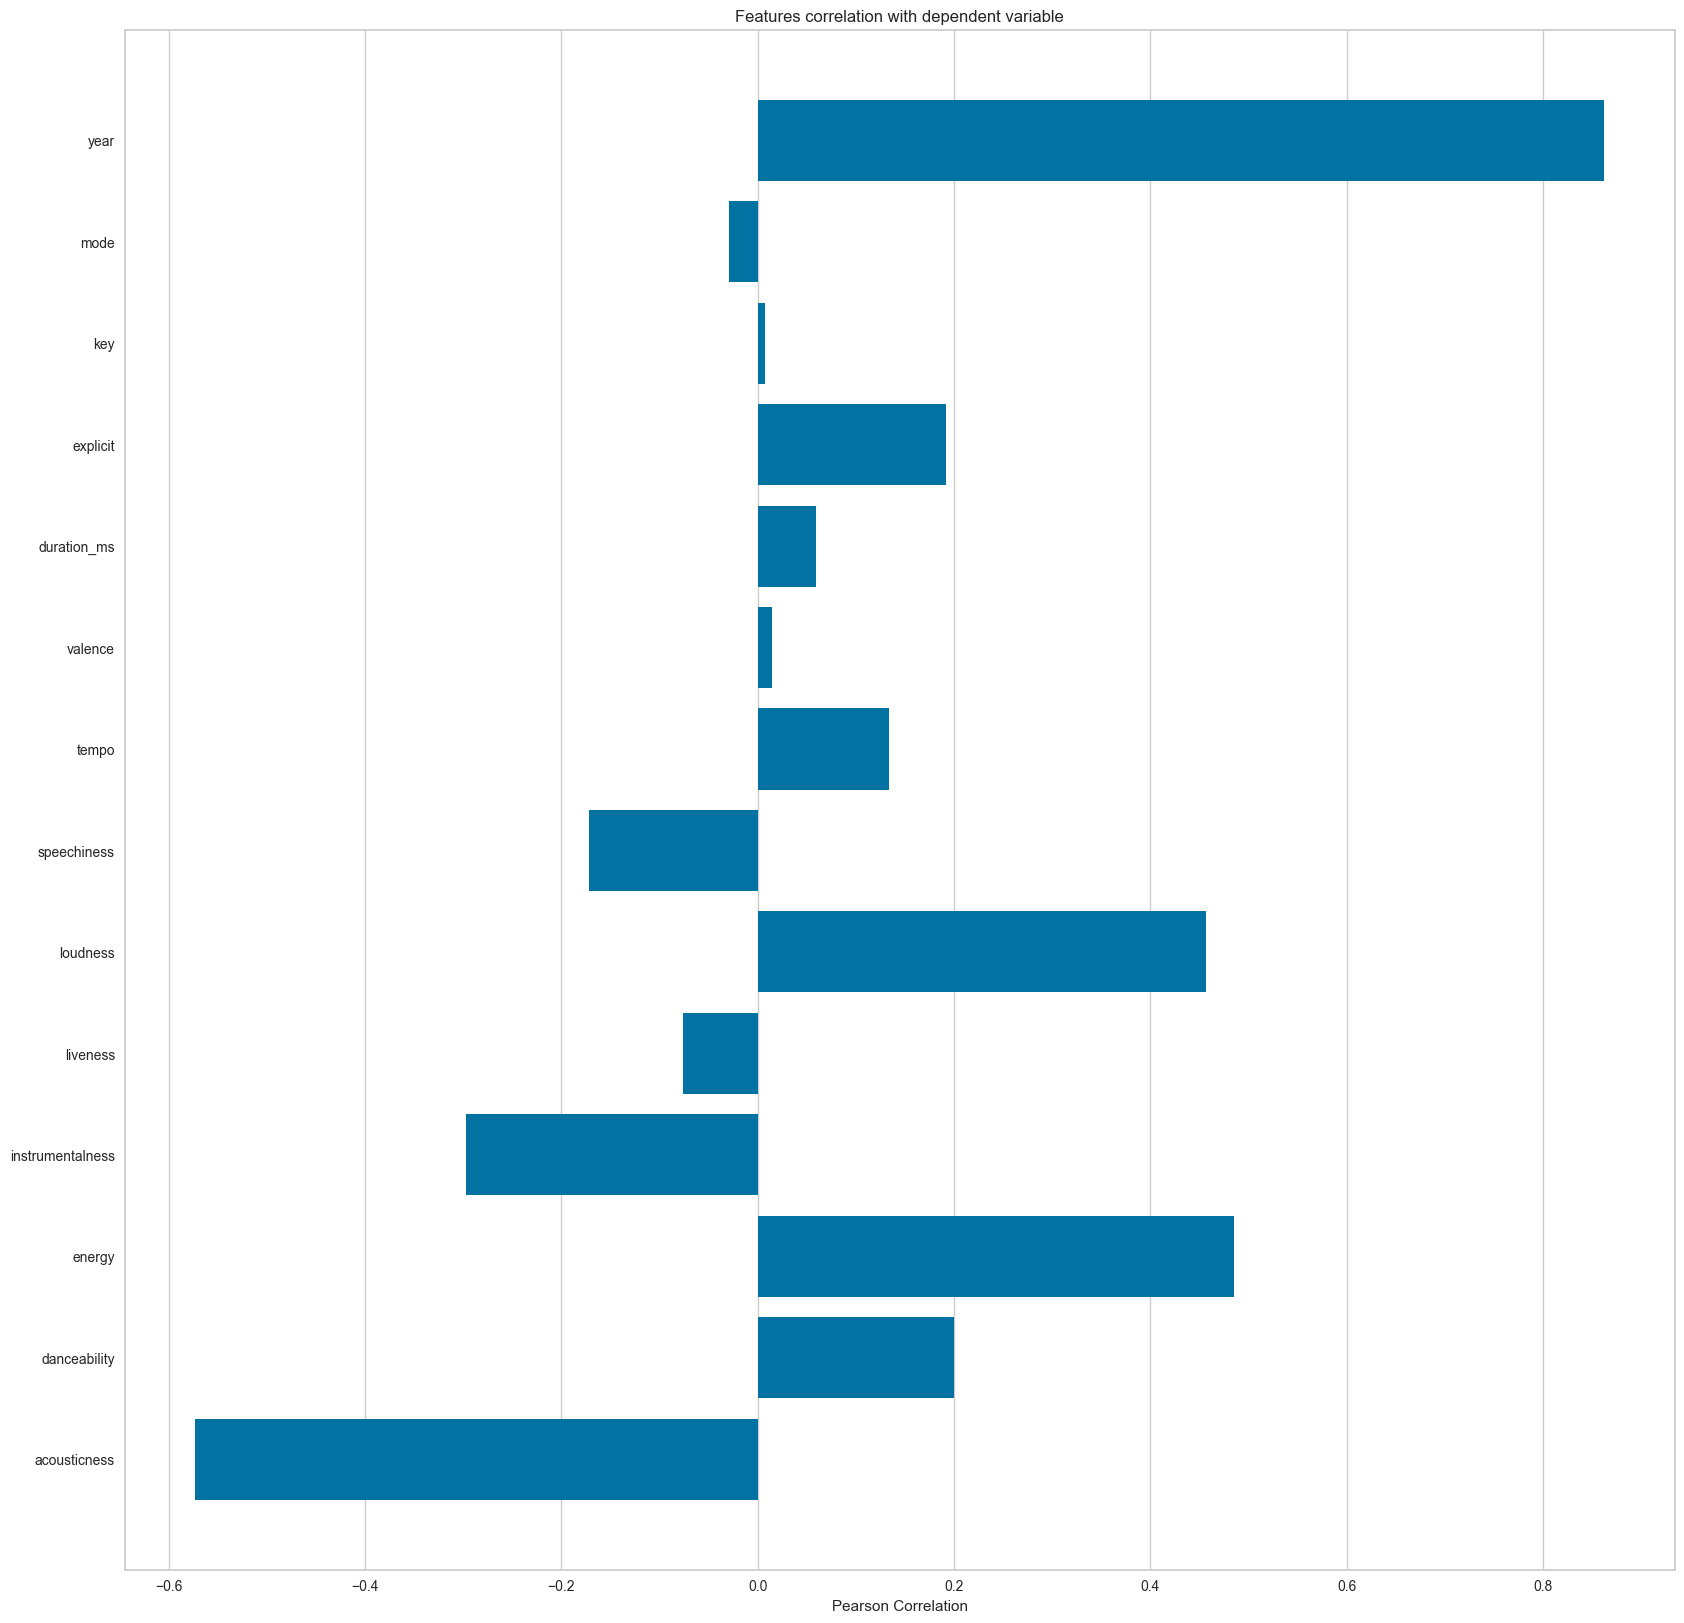

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [344]:
from yellowbrick.target import FeatureCorrelation 

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year'] 

X, y = data[feature_names], data['popularity'] 
features = np.array(feature_names) # convert to numpy array for indexing
visualizer = FeatureCorrelation(labels=features) # Instantiate the visualizer with the Covariance ranking algorithm

plt.rcParams['figure.figsize']=(20,20) # set the size of the plot
visualizer.fit(X, y) # Fit the data to the visualizer      
visualizer.show() # Finalize and render the figure

In [345]:
# create a plotly figure
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
fig = px.line(year_data, x='year', y=sound_features, title='Trend of sound features over decades')
fig.show() 

In [346]:
# create a plotly figure
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'], barmode='group',
            title='Characteristics of top 10 genres') 
fig.show()

## 1.7 - Content Based Recommendation

#### k-NN

###### The KNN algorithm is used to find the most similar songs to a given query song, based on their feature (such as loudness, tempo, and danceability) values. The data is preprocessed by rescaling values and dropping unnecessary features. The algorithm is trained on the dataset using a kd-tree implementation, which makes the nearest neighbor search more efficient.
###### The recommendation function takes as input a song ID and returns the top n (default is 5) most similar songs to that query song. The function uses the trained KNN model to find the nearest neighbors based on feature values and prints out the names and artists of the recommended songs.
###### This is a content-based recommendation system, as it only takes into account the features of the songs and not user preferences or behavior. The algorithm uses similarity in features to make recommendations.

In [347]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [348]:
# Group by song name and count the number of unique artists
grouped_by_song = data.groupby('name')['artists'].nunique()

# Filter out unique song names and count the number of groups with more than 1 artist
song_names_with_diff_artists = grouped_by_song[grouped_by_song > 1]
count = sum(song_names_with_diff_artists)

# Print the result
print(f'There are {count} unique song names with different artists.')

# Get an example of a song name in the list
song_name = song_names_with_diff_artists.index[64]

# Print all the rows with that song name
print(f'All the rows with the song name "{song_name}":')
print(data.loc[data['name'] == song_name])

There are 35415 unique song names with different artists.
All the rows with the song name "365":
        valence  year  acousticness                 artists  danceability  \
162764    0.689  1981         0.393         ['Teena Marie']         0.702   
170356    0.248  2019         0.339  ['Zedd', 'Katy Perry']         0.745   

        duration_ms  energy  explicit                      id  \
162764       260293   0.931         0  7w7OoMSngihtJTSbG8HLWV   
170356       181900   0.693         0  2XWjPtKdi5sucFYtVav07d   

        instrumentalness  key  liveness  loudness  mode name  popularity  \
162764               0.0    7     0.579    -7.722     1  365          20   
170356               0.0    2     0.123    -5.479     0  365          71   

       release_date  speechiness    tempo  
162764   1981-05-14        0.167  113.588  
170356   2019-02-14        0.034   98.039  


In [349]:
# create a new dataframe and drop the columns that are not needed for the clustering 
df_for_kNN = data.drop(['artists','duration_ms','explicit','key','mode','name','popularity','release_date','year'],axis=1) 
df_for_kNN.head() # check the new dataframe

,valence,acousticness,danceability,energy,id,instrumentalness,liveness,loudness,speechiness,tempo
0,0.0594,0.982,0.279,0.211,4BJqT0PrAfrxzMOxytFOIz,0.878000,0.665,-20.096,0.0366,80.954
1,0.9630,0.732,0.819,0.341,7xPhfUan2yNtyFG0cUWkt8,0.000000,0.160,-12.441,0.4150,60.936
2,0.0394,0.961,0.328,0.166,1o6I8BglA6ylDMrIELygv1,0.913000,0.101,-14.850,0.0339,110.339
3,0.1650,0.967,0.275,0.309,3ftBPsC5vPBKxYSee08FDH,0.000028,0.381,-9.316,0.0354,100.109
4,0.2530,0.957,0.418,0.193,4d6HGyGT8e121BsdKmw9v6,0.000002,0.229,-10.096,0.0380,101.665


In [350]:
# Compute the minimum and maximum values for each column
for col in df_for_kNN.columns:
    min_val = df_for_kNN[col].min()
    max_val = df_for_kNN[col].max()
    print(f"{col}: min={min_val}, max={max_val}")

valence: min=0.0, max=1.0
acousticness: min=0.0, max=0.996
danceability: min=0.0, max=0.988
energy: min=0.0, max=1.0
id: min=000G1xMMuwxNHmwVsBdtj1, max=7zzuPsjj9L3M7ikqGmjN0D
instrumentalness: min=0.0, max=1.0
liveness: min=0.0, max=1.0
loudness: min=-60.0, max=3.855
speechiness: min=0.0, max=0.97
tempo: min=0.0, max=243.507


In [351]:
# rescale values and change ID to be primary key Spotify ID
df_for_kNN['loudness'] = df_for_kNN['loudness']+60 # since the minimum value is -60 and we want to make it 0
df_for_kNN['loudness'] = df_for_kNN['loudness']/63.855 # since the maximum value is now 63.855 and we want to make it 1
df_for_kNN['tempo'] = df_for_kNN['tempo']/244.091 # since the maximum value is 244.091 and we want to make it 1
df_for_kNN.index = df_for_kNN['id'] # change index to be the id
df_for_kNN = df_for_kNN.drop(['id'],axis=1) # remove id column
df_for_kNN.head() # check if everything is ok


,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,
4BJqT0PrAfrxzMOxytFOIz,0.0594,0.982,0.279,0.211,0.878000,0.665,0.624916,0.0366,0.331655
7xPhfUan2yNtyFG0cUWkt8,0.9630,0.732,0.819,0.341,0.000000,0.160,0.744797,0.4150,0.249645
1o6I8BglA6ylDMrIELygv1,0.0394,0.961,0.328,0.166,0.913000,0.101,0.707071,0.0339,0.452040
3ftBPsC5vPBKxYSee08FDH,0.1650,0.967,0.275,0.309,0.000028,0.381,0.793736,0.0354,0.410130
4d6HGyGT8e121BsdKmw9v6,0.2530,0.957,0.418,0.193,0.000002,0.229,0.781521,0.0380,0.416505


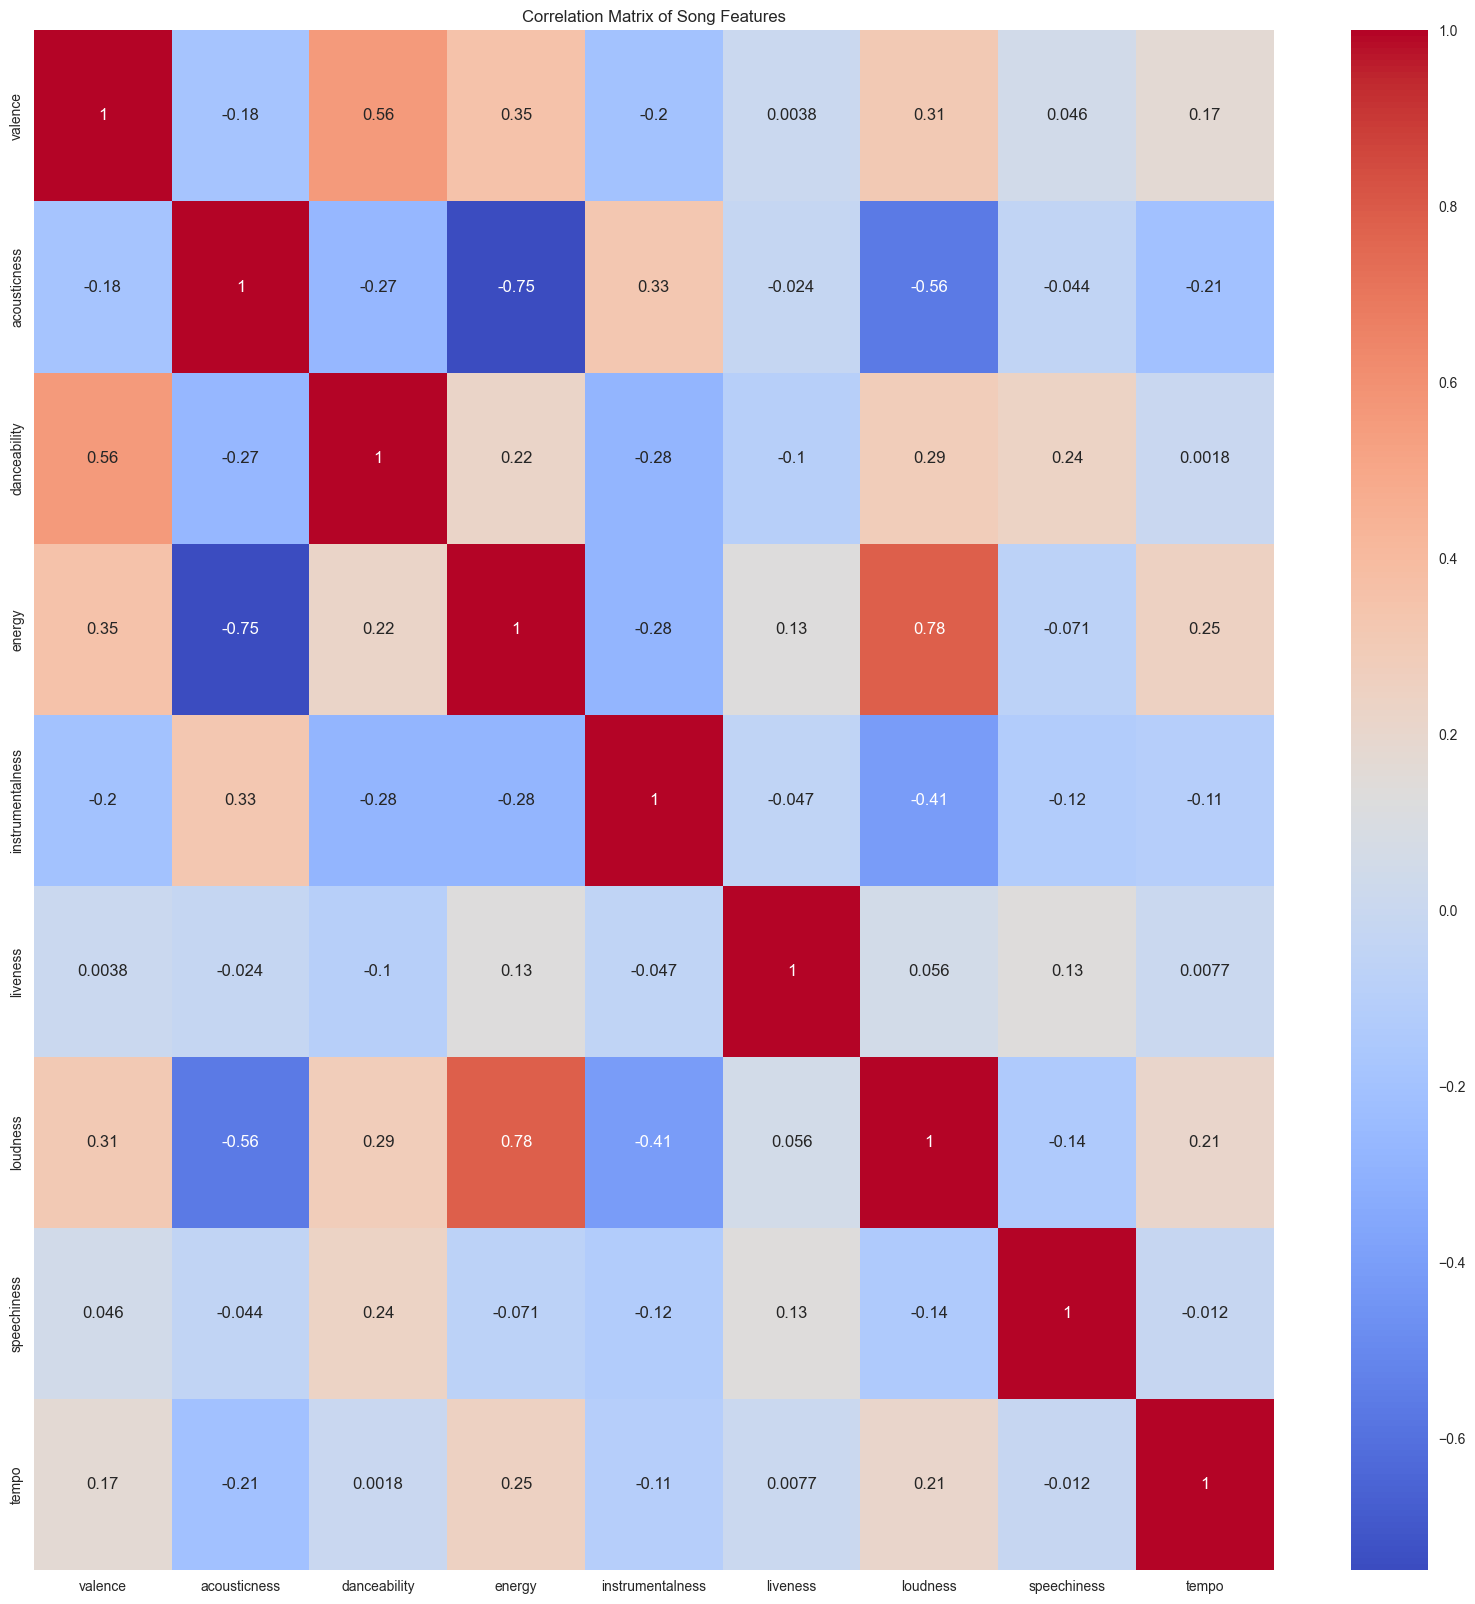

In [352]:
# visualisation
corr_matrix = df_for_kNN.corr() # Compute the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True) # Plot the correlation matrix as a heatmap
plt.title('Correlation Matrix of Song Features') 
plt.show() 

In [353]:
model_knn = NearestNeighbors(algorithm='kd_tree',n_neighbors=50) # Create a KNN model 

In [354]:
mat_songs = csr_matrix(df_for_kNN.values) # Create a sparse matrix

In [355]:
model_knn.fit(mat_songs) # Fit the model to the sparse matrix

NearestNeighbors(algorithm='kd_tree', n_neighbors=50)

In [362]:
def recommend(id_song, model, number_of_recommendations=5): # Create a function to recommend songs
    query = df_for_kNN.loc[id_song].to_numpy().reshape(1,-1) # Get the song features
    print('Searching for recommendations...')
    distances, indices = model.kneighbors(query,n_neighbors = number_of_recommendations) # Get the distances and indices of the nearest songs

    # Loop through the indices and print the song names and artists of the nearest songs
    for i, index in enumerate(indices[0]):
     if index != id_song:
        song_info = data[['name','artists']].loc[index]
        print(f"{i+1}. {song_info['name']} by {song_info['artists']}")

In [363]:
name = input('Enter song title: ') # Get the song title from the user
print('Song title search results: ') 
print(data[['artists','name']].where(data['name'] == name).dropna()) # Print the search results

song_ind = int(input('Enter the index value of the requested song: ')) # Get the index value of the song from the user since more than one song can have the same name
id_song = data['id'].loc[song_ind] # Get the song id

song = data['name'].loc[song_ind] # Get the song nam
artists = data['artists'].loc[song_ind] # Get the song artists

print('Song selected is ', song, 'by', artists) 

nor = int(input('Enter number of recommendations: ')) # Get the number of recommendations (nor) from the user

recommend(id_song, model_knn, nor) # Call the recommend function

Song title search results: 
                       artists name
162764         ['Teena Marie']  365
170356  ['Zedd', 'Katy Perry']  365
Song selected is  365 by ['Zedd', 'Katy Perry']
Searching for recommendations...
                                                     name  \
73442                        Like Whaaat (feat. Bad Lucc)   
162213                                       How Are You?   
72668                                       La Dolce Vita   
57131                                         Red Kingdom   
38039                    Beautiful (feat. Camila Cabello)   
108690                                              Diosa   
165251                        Epilogue (Nothing 'Bout Me)   
169650                                              Stung   
35879   Start of Something New - From "High School Mus...   

                             artists  
73442        ['Problem', 'Bad Lucc']  
162213               ['Cheap Trick']  
72668                ['Warren Hill']  
57131           